# Jupyter notebook

`genomeinterv` provides support for working with intervals on genomes. A genomic interval is specified as a chromosome, start, and end. It is half-open so that a value `x` is in an interval `(start, end)` included in the inrval if `start <= x and x < end`. All functions take pandas.DataFrames as arguments. These data frames must include chrom, start, and end columns.

See the [library reference](https://genominterv.readthedocs.io/en/latest/) for detailed documentation of each function and decorator.

In [1]:
import genominterv
import pandas as pd

In [ ]:
#| echo: false

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'


## Set operations

The three functions `interval_diff`, `interval_intersect`, and `interval_union` do the standard difference, intersection and union set operations on two sets of genomic intervals.

The intervals returned from all three functions are collapsed to produce non-overlapping intervals. The genomic intervals in each set must be non-overlapping. This can be achieved using function `interval_collapse`, which produces the union of genomic intervals in a single set genomic of intervals.

Try it out on two sets of intervals: `annot` and `query`:

In [138]:
intervals = [('chr1', 1, 3), ('chr1', 4, 6), ('chr1', 5, 10), ('chr1', 25, 30), ('chr1', 20, 27), ('chr2', 1, 10), ('chr2', 1, 3)]
annot = pd.DataFrame.from_records(intervals, columns=['chrom', 'start', 'end'])
annot

,chrom,start,end
0,chr1,1,3
1,chr1,4,6
2,chr1,5,10
3,chr1,25,30
4,chr1,20,27
5,chr2,1,10
6,chr2,1,3


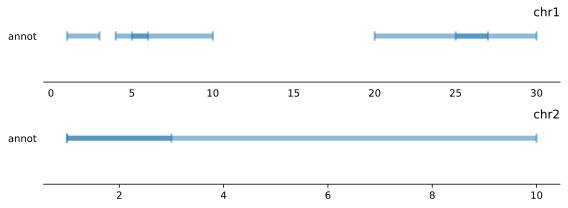

In [139]:
#| echo: false
#| label: fig-intervals
#| fig-cap: "Intervals"
plot_intervals(annot=annot)

In [140]:
intervals = [('chr1', 8, 22), ('chr2', 14, 15)]
query = pd.DataFrame.from_records(intervals, columns=['chrom', 'start', 'end'])
query

,chrom,start,end
0,chr1,8,22
1,chr2,14,15


In [141]:
from genominterv import interval_collapse

annot_collapsed = interval_collapse(annot)
annot_collapsed

,index,start,end,chrom
0,0,1,3,chr1
1,1,4,10,chr1
2,2,20,30,chr1
3,0,1,10,chr2


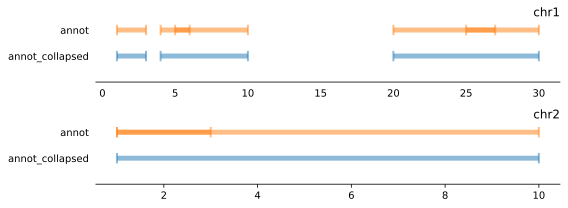

In [142]:
#| echo: false
#| label: fig-collapse
#| fig-cap: "Collapsed intervals"
plot_intervals(annot=annot, annot_collapsed=annot_collapsed)

In [143]:
annot = annot_collapsed

In [144]:
from genominterv import interval_diff

non_ovl_query = interval_diff(query, annot)
non_ovl_query

,index,start,end,chrom
0,0,10,20,chr1
1,0,14,15,chr2


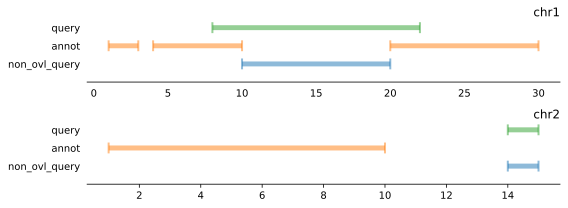

In [145]:
#| echo: false
#| label: fig-nonoverlap
#| fig-cap: "Non-overlapping intervals"
plot_intervals(query=query, annot=annot, non_ovl_query=non_ovl_query)

In [146]:
from genominterv import interval_intersect

intersection = interval_intersect(query, annot)
intersection

,index,start,end,chrom
0,0,8,10,chr1
1,1,20,22,chr1


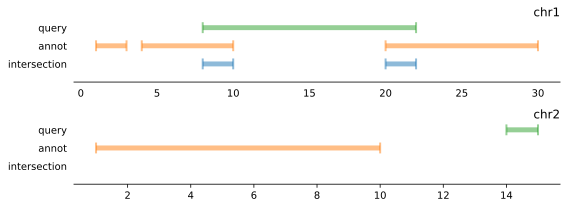

In [147]:
#| echo: false
#| label: fig-intersect
#| fig-cap: "Intersection of intervals"
plot_intervals(query=query, annot=annot, intersection=intersection)

In [148]:
from genominterv import interval_union

union = interval_union(query, annot)
union

,index,start,end,chrom
0,0,1,3,chr1
1,1,4,30,chr1
2,0,1,10,chr2
3,1,14,15,chr2


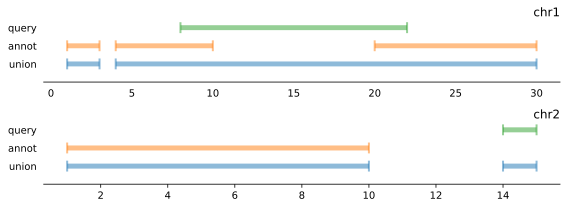

In [149]:
#| echo: false
#| label: fig-union
#| fig-cap: "Union of intervals"
plot_intervals(query=query, annot=annot, union=union)

To make it easy to create other interval functions that work across chromosomes, the module provides a genomic decorator that can be applied to functions that operate lists of `(start, end)` tuples. Applying the decorator changes the signature of a function to make it operate on DataFrames that include `chrom`, `start`, and `end` columns. 

Here is an example function that shifts the interval coordinates by 1000bp:

In [150]:
intervals = pd.DataFrame(dict(chrom='chrX', start=[1, 20], end=[2, 25]))
intervals

,chrom,start,end
0,chrX,1,2
1,chrX,20,25


In [151]:
from genominterv import genomic

@genomic
def inverval_shift(interv):
    return [(start+1000, end+1000) for (start, end) in interv]

shifted = inverval_shift(intervals)
shifted

,index,start,end,chrom
0,0,1001,1002,chrX
1,1,1020,1025,chrX


## Remapping functions

The function `remap` converts coordinates a single interval into distance to the closest interval in a second set:

In [79]:
single_interval = (300, 400)
other_intervals = [(0, 100), (1000, 1100)]

genominterv.remap(single_interval, other_intervals)

[(200, 300)]

Same but retaining info about which annotation the interval is proximal to:

In [80]:
genominterv.remap((300, 400), [(0, 100), (1000, 1100)], include_prox_coord=True)

[(200, 300, 0, 100)]

The function `interval_distance` converts coordinates of one set of genomic intervals into distances to the closest interval in a second set. `interval_relative_distance` does the same but returns relative distances.

In [81]:
annot = pd.DataFrame(dict(chrom='chrX', start=[1, 20], end=[2, 25]))
annot

,chrom,start,end
0,chrX,1,2
1,chrX,20,25


In [82]:
query = pd.DataFrame(dict(chrom='chrX', start=[3, 5], end=[15, 7], some_data=['foo', 'bar'], other_data=['A', 'B']))
query

,chrom,start,end,some_data,other_data
0,chrX,3,15,foo,A
1,chrX,5,7,bar,B


In [83]:
from genominterv import interval_distance

interval_distance(query, annot)

,index,start,end,chrom
0,0,1,9,chrX
1,1,-5,-9,chrX
2,2,3,5,chrX


In [84]:
from genominterv import interval_relative_distance

interval_relative_distance(query, annot)

,index,start,end,chrom
0,0,0.055556,0.500000,chrX
1,1,-0.277778,-0.500000,chrX
2,2,0.166667,0.277778,chrX


The most useful function for most applications is `remap_interval_data`, which does the remapping while preserving all the information in the query data frame. It also reports the start and end coordinates before remapping (ends with `*_orig`) and the coordinates of the most proximal segment in the annotation set (`*_prox`).

In [85]:
from genominterv import remap_interval_data

remap_interval_data(query, annot)

,start,end,start_prox,end_prox,chrom,start_orig,end_orig,some_data,other_data
0,1,9,1,2,chrX,3,15,foo,A
1,-5,-9,20,25,chrX,3,15,foo,A
2,3,5,1,2,chrX,5,7,bar,B


## Ready-made tests

`proximity_test` computes tests if intervals in one set is significantly proximal to intervals in another set. 

In [21]:
from genominterv import proximity_test

annot = pd.DataFrame(dict(chrom='chr1',
                          start=list(range(1, 1000, 100)),
                          end=list(range(20, 1020, 100))))
query = pd.DataFrame(dict(chrom='chr1',
                          start=list(range(1, 1000, 10)),
                          end=list(range(10, 1010, 10))))

The annotation intervals cannot overlap each other or any of the query intervals:

In [22]:
annot_collapsed = interval_collapse(annot)
non_ovl_query = interval_diff(query, annot_collapsed)

In [23]:
proximity_test(non_ovl_query, annot_collapsed)

TestResult(statistic=-0.02112359550561797, pvalue=0.6351)

## Two-set statistics

The module also provides two statistics for relations between sets: `jaccard` computes the Jaccard index statistic for two sets of genomic intervals.

In [24]:
annot = pd.DataFrame(dict(chrom='chrX', start=[2, 9, 20], end=[4, 14, 25], some_data=['foo', 'bar', 'baz']))
annot

,chrom,start,end,some_data
0,chrX,2,4,foo
1,chrX,9,14,bar
2,chrX,20,25,baz


In [25]:
query = pd.DataFrame(dict(chrom='chrX', start=[3, 7], end=[5, 10], some_data=['foo', 'bar'], other_data=['A', 'B']))
query

,chrom,start,end,some_data,other_data
0,chrX,3,5,foo,A
1,chrX,7,10,bar,B


In [26]:
from genominterv import jaccard_stat

jaccard_stat(query, annot)

0.13333333333333333

## Bootstrap decorator

The module provides a `bootstrap` decorator that turns a function producing a statistic into one that also produces a p-value. The bootstrapping resamples the intervals of the second argument for each chromosome independently. Only required argument to bootstrap is the name of the chromosome assembly used. The decorator works on any function that takes two sets of intervals.

This example does this for the provided `jaccard` satistic:

In [ ]:
from genominterv import bootstrap

@bootstrap('hg19', samples=1000)
def jaccard_test(query, annot):
    return jaccard_stat(query, annot)

jaccard_stat, p_value = jaccard_test(query, annot)